<a href="https://colab.research.google.com/github/praveenravi01/data-science-assignment/blob/main/Lookalike.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Customers dataset:
  CustomerID        CustomerName         Region  SignupDate
0      C0001    Lawrence Carroll  South America  2022-07-10
1      C0002      Elizabeth Lutz           Asia  2022-02-13
2      C0003      Michael Rivera  South America  2024-03-07
3      C0004  Kathleen Rodriguez  South America  2022-10-09
4      C0005         Laura Weber           Asia  2022-08-15

Products dataset:
  ProductID              ProductName     Category   Price
0      P001     ActiveWear Biography        Books  169.30
1      P002    ActiveWear Smartwatch  Electronics  346.30
2      P003  ComfortLiving Biography        Books   44.12
3      P004            BookWorld Rug   Home Decor   95.69
4      P005          TechPro T-Shirt     Clothing  429.31

Transactions dataset:
  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166   

<ipython-input-1-078cdaeb8a79>:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=customers, x='Region', palette='viridis')


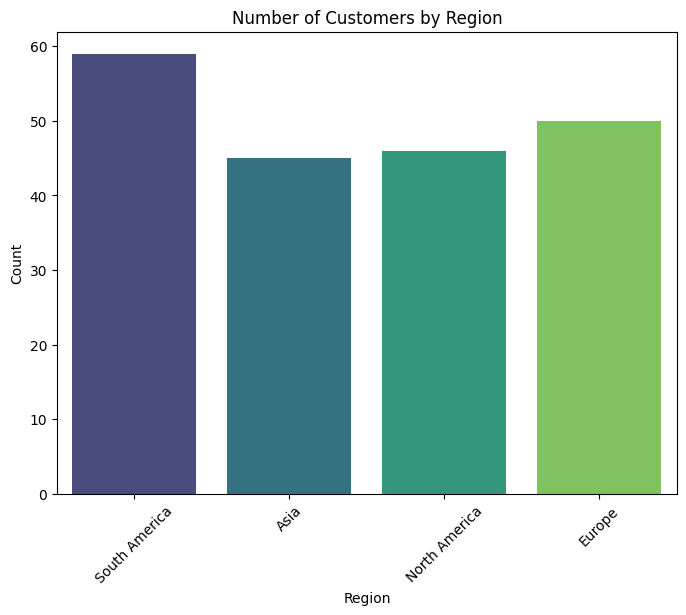


Products Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ProductID    100 non-null    object 
 1   ProductName  100 non-null    object 
 2   Category     100 non-null    object 
 3   Price        100 non-null    float64
dtypes: float64(1), object(3)
memory usage: 3.3+ KB
None

Product Categories:
Category
Books          26
Electronics    26
Clothing       25
Home Decor     23
Name: count, dtype: int64


<ipython-input-1-078cdaeb8a79>:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=products, y='Category', palette='cool')


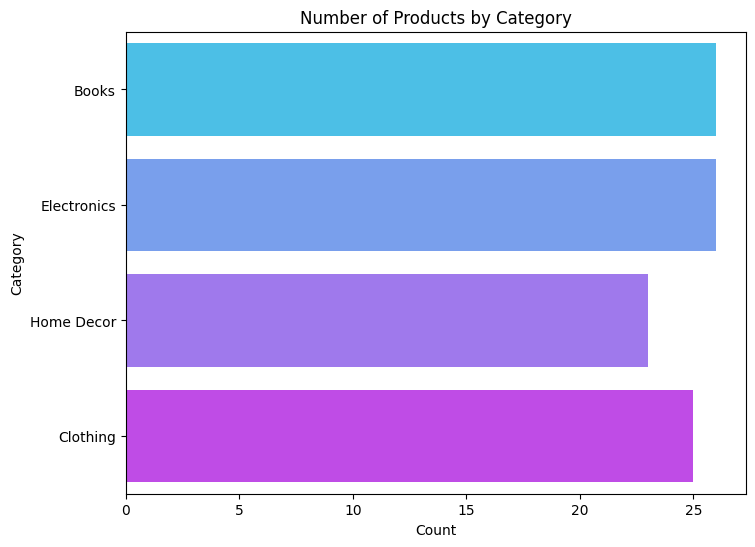


Transactions Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   TransactionID    1000 non-null   object 
 1   CustomerID       1000 non-null   object 
 2   ProductID        1000 non-null   object 
 3   TransactionDate  1000 non-null   object 
 4   Quantity         1000 non-null   int64  
 5   TotalValue       1000 non-null   float64
 6   Price            1000 non-null   float64
dtypes: float64(2), int64(1), object(4)
memory usage: 54.8+ KB
None

Top 5 Products by Total Sales Value:
ProductID
P029    19513.80
P079    17946.91
P048    17905.20
P020    15060.92
P062    14592.24
Name: TotalValue, dtype: float64


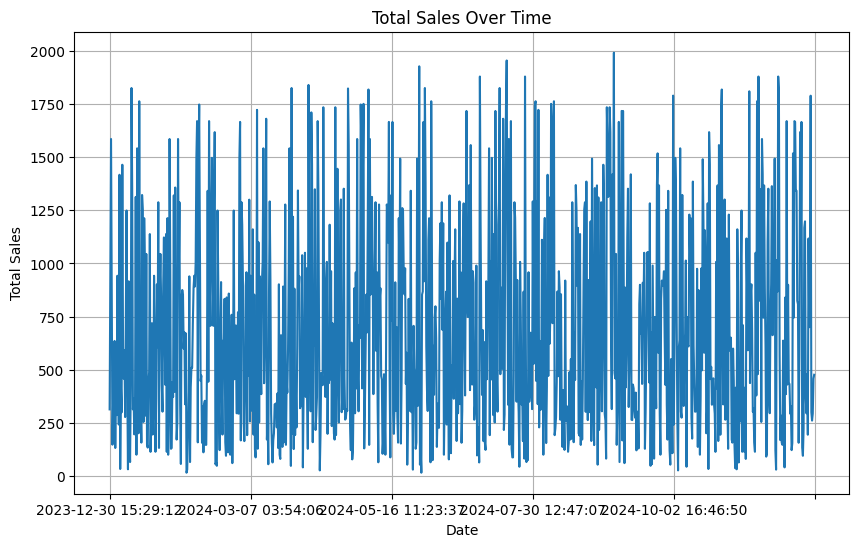


Merged Data Preview:
  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127      P067  2024-04-25 07:38:55         1   
3        T00272      C0087      P067  2024-03-26 22:55:37         2   
4        T00363      C0070      P067  2024-03-21 15:10:10         3   

   TotalValue  Price_x     CustomerName         Region  SignupDate  \
0      300.68   300.68   Andrea Jenkins         Europe  2022-12-03   
1      300.68   300.68  Brittany Harvey           Asia  2024-09-04   
2      300.68   300.68  Kathryn Stevens         Europe  2024-04-04   
3      601.36   300.68  Travis Campbell  South America  2024-04-11   
4      902.04   300.68    Timothy Perez         Europe  2022-03-15   

                       ProductName     Category  Price_y  
0  ComfortLiving Bluetooth Speaker  Electronics   300.68  
1  ComfortLi

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
customers = pd.read_csv('/content/Customers.csv' )
products = pd.read_csv('/content/Products.csv')
transactions = pd.read_csv('/content/Transactions.csv')

# Preview the datasets
print("Customers dataset:")
print(customers.head())
print("\nProducts dataset:")
print(products.head())
print("\nTransactions dataset:")
print(transactions.head())

# EDA on Customers dataset
print("\nCustomers Dataset Info:")
print(customers.info())

print("\nUnique Regions:")
print(customers['Region'].value_counts())

plt.figure(figsize=(8, 6))
sns.countplot(data=customers, x='Region', palette='viridis')
plt.title('Number of Customers by Region')
plt.xlabel('Region')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# EDA on Products dataset
print("\nProducts Dataset Info:")
print(products.info())

print("\nProduct Categories:")
print(products['Category'].value_counts())

plt.figure(figsize=(8, 6))
sns.countplot(data=products, y='Category', palette='cool')
plt.title('Number of Products by Category')
plt.xlabel('Count')
plt.ylabel('Category')
plt.show()

# EDA on Transactions dataset
print("\nTransactions Dataset Info:")
print(transactions.info())

print("\nTop 5 Products by Total Sales Value:")
product_sales = transactions.groupby('ProductID')['TotalValue'].sum().sort_values(ascending=False)
print(product_sales.head())

plt.figure(figsize=(10, 6))
transactions.groupby('TransactionDate').sum()['TotalValue'].plot()
plt.title('Total Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.grid(True)
plt.show()

# Merging datasets for combined analysis
merged_data = transactions.merge(customers, on='CustomerID').merge(products, on='ProductID')
print("\nMerged Data Preview:")
print(merged_data.head())

# Insights
# 1. Analyze customer distribution by region.
# 2. Identify top-selling products and categories.
# 3. Observe sales trends over time.
# 4. Analyze customer purchasing patterns.
# 5. Examine relationships between customer regions and purchasing behaviors.
